In [1]:
%matplotlib inline

import os
import sys
import struct
from time import time

sys.path.append("/home/matthew/lscsoft/.virtualenvs/lalapps_knope_O2/lib/python2.7/site-packages")

import numpy as np
from matplotlib import pyplot as pl

import lalpulsar

In [2]:
%load_ext Cython

In [5]:
%%cython --compile-args=-O2

import numpy as np
cimport numpy as np

from libc.math cimport sqrt, cos, sin

from lalpulsar import ComputeEccentricAnomaly

# function to return binary BT model
def binary_model(w0, T0, Pb, asini, ecc, gamma, ts):
    # calculate the binary time delay for a Keplerian orbit (including gamma parameter
    # that accounts for relativistic Einstein delay effects)
    
    orbits = (ts - T0)/Pb
    
    phase = 2.*np.pi*np.fmod(orbits, 1.)

    l = len(phase)
    u = np.zeros(l)
    for i in xrange(l):
        u[i] = ComputeEccentricAnomaly(phase[i], ecc)

    su = np.sin(u)
    cu = np.cos(u)
    
    sw = np.sin(w0)
    cw = np.cos(w0)
    
    x = asini
    e = ecc
    
    one_e2 = sqrt(1. - e**2)
    
    deltaTW1 = x*(sw*(cu - e) + (cw*one_e2 + (gamma/x))*su)
    deltaTW2 = (2.*np.pi*x/Pb)*(cw*one_e2*cu - sw*su)/(1.0 - e*cu)
    
    dt = -(deltaTW1*(1. - deltaTW2))
    
    return dt, su, cu

def eccentric_anomaly( T0, Pb, ecc, ts ):
    # calculate sine and cosine of the eccentric anomaly
    
    orbits = (ts - T0)/Pb
    phase = 2.*np.pi*np.fmod(orbits, 1.)
    l = len(phase)
    su = np.zeros(l)
    cu = np.zeros(l)
    for i in xrange(l):
        u = ComputeEccentricAnomaly(phase[i], ecc)
        su[i] = sin(u)
        cu[i] = cos(u)

    return su, cu

def binary_model_EA(w0, Pb, asini, ecc, gamma, sinU, cosU):
    # compute the binary time delay when passed the sine and cosine of the eccentric anomaly U
    
    sw = np.sin(w0)
    cw = np.cos(w0)

    x = asini
    e = ecc

    one_e2 = sqrt(1. - e**2)

    tw1 = x*sw*(cosU - e) + (x*cw*one_e2 + gamma)*sinU
    tw2 = (2.*np.pi*x/Pb)*(cw*one_e2*cosU - sw*sinU)/(1.0 - e*cosU)

    return -tw1*(1. - tw2)

In [6]:
# show test of residuals
rundir1 = '/home/matthew/repositories/greedycpp/scripts/barycenter/binary/term1'

# get time stamps
ts = np.loadtxt(os.path.join(rundir1, 'quad_rule.txt'))
t = ts[:,0]

lenb = len(t)

# get number of basis
Nb1 = np.loadtxt(os.path.join(rundir1, 'ApproxErrors.txt')).shape[0]

# read in binary version of reduced basis data
bf = open(os.path.join(rundir1,'Basis.bin'), 'rb')
fc = bf.read()
bf.close()

rb1 = np.zeros((Nb1,lenb))
for i in range(Nb1):
    tmpvals = struct.unpack('d'*lenb*2, fc[(i*8*lenb*2):(i+1)*8*lenb*2])
    rb1[i] = tmpvals[::2] # just get real part
    
# read in binary version of empirical interpolation matrix
invV1 = np.zeros((Nb1, Nb1))
bf = open(os.path.join(rundir1,'invV.bin'), 'rb')
fc = bf.read()
bf.close()
for i in range(Nb1):
    tmpvals = struct.unpack('d'*Nb1*2, fc[(i*8*Nb1*2):(i+1)*8*Nb1*2])
    invV1[i] = tmpvals[::2] # just get real part
    
# show test of residuals
rundir2 = '/home/matthew/repositories/greedycpp/scripts/barycenter/binary/term2'

# get number of basis
Nb2 = np.loadtxt(os.path.join(rundir2, 'ApproxErrors.txt')).shape[0]

# read in binary version of reduced basis data
bf = open(os.path.join(rundir2,'Basis.bin'), 'rb')
fc = bf.read()
bf.close()

rb2 = np.zeros((Nb2,lenb))
for i in range(Nb2):
    tmpvals = struct.unpack('d'*lenb*2, fc[(i*8*lenb*2):(i+1)*8*lenb*2])
    rb2[i] = tmpvals[::2] # just get real part
    
# read in binary version of empirical interpolation matrix
invV2 = np.zeros((Nb2, Nb2))
bf = open(os.path.join(rundir2,'invV.bin'), 'rb')
fc = bf.read()
bf.close()
for i in range(Nb2):
    tmpvals = struct.unpack('d'*Nb2*2, fc[(i*8*Nb2*2):(i+1)*8*Nb2*2])
    invV2[i] = tmpvals[::2] # just get real part

In [7]:
# get random phases, start times and eccentricities and check residuals
nbins = 1000

# fixed parameters
Pb = 3600.

eccmax = 0.1 # maximum eccentricity of the basis set
ecc = eccmax*np.random.rand(nbins)
w0 = 2.*np.pi*np.random.rand(nbins)
T0 = np.random.rand(nbins)
asini = 10.*np.random.rand(nbins)
gamma = 1e-3*np.random.rand(nbins)

deltaTs = np.zeros(lenb)
deltaTsArray = []

par = lalpulsar.PulsarParameters()

binarytype = "BT"
lalpulsar.PulsarAddREAL8Param( par, "PB", Pb )
lalpulsar.PulsarAddStringParam( par, "BINARY", binarytype )

# get deltaTs calculated over all times using LALBarycenter routines
for i in range(nbins):
    bininput = lalpulsar.BinaryPulsarInput()
    binoutput = lalpulsar.BinaryPulsarOutput()

    lalpulsar.PulsarAddREAL8Param( par, "ECC", ecc[i] )
    lalpulsar.PulsarAddREAL8Param( par, "OM", w0[i] )
    lalpulsar.PulsarAddREAL8Param( par, "T0", t[0]+T0[i]*Pb )
    lalpulsar.PulsarAddREAL8Param( par, "GAMMA", gamma[i] )
    lalpulsar.PulsarAddREAL8Param( par, "A1", asini[i] )

    # set GPS time
    for j, tv in enumerate(t):
        bininput.tb = tv
        
        # perform binary barycentring
        lalpulsar.BinaryPulsarDeltaTNew( binoutput, bininput, par )
        deltaTs[j] = binoutput.deltaT
    
    deltaTsArray.append(np.copy(deltaTs))

In [9]:
# perform some timing evalution
ts = np.zeros(len(t))
tsTW1 = np.zeros(len(t))
tsTW2 = np.zeros(len(t))

ta = time()
dt, deltaTW1, deltaTW2 = binary_model(w0[-1], t[0]+T0[-1]*Pb, Pb, asini[-1], ecc[-1], gamma[-1], t)
tb = time()

print("Total time for evalution = %.9f" % (tb-ta))
print("time for one evaluation = %.9f" % ((tb-ta)/len(t)))

Total time for evalution = 0.001717091
time for one evaluation = 0.000000477


In [10]:
# get deltaTs calculated using interpolant
SU = []
dtvals = np.zeros(Nb1)

ts_nodes1 = np.loadtxt(os.path.join(rundir1, 'EIM_nodes.txt'))

B1 = np.einsum('ik,ij->kj', invV1, rb1)

# get deltats calculated using the reduced basis
for i in range(nbins):
    # get values of eccentric anomaly at given points
    su, cu = eccentric_anomaly(t[0]+T0[i]*Pb, Pb, ecc[i], ts_nodes1)
        
    # create new version of deltaTs using empirical interpolant matrix
    SU.append(np.einsum('i,ij->j', su, B1))

# time linear algebra
%timeit np.einsum('i,ij->j', su, B1)
%timeit np.dot(su, B1)

# get deltaTs calculated using interpolant
CU = []
dtvals = np.zeros(Nb2)

ts_nodes2 = np.loadtxt(os.path.join(rundir2, 'EIM_nodes.txt'))

B2 = np.einsum('ik,ij->kj', invV2, rb2)

# get deltats calculated using the reduced basis
for i in range(nbins):
    # get values of eccentric anomaly at given points
    su, cu = eccentric_anomaly(t[0]+T0[i]*Pb, Pb, ecc[i], ts_nodes2)
    
    # create new version of deltaTs using empirical interpolant matrix
    CU.append(np.einsum('i,ij->j', cu, B2))

# time linear algebra
%timeit np.einsum('i,ij->j', cu, B2)
%timeit np.dot(cu, B2)

deltaTsArrayFull = []
for i in range(nbins):
    deltaTsArrayFull.append(binary_model_EA(w0[i], Pb, asini[i], ecc[i], gamma[i], SU[i], CU[i]))
    
%timeit lambda x: binary_model_EA(w0[i], Pb, asini[i], ecc[i], gamma[i], SU[i], CU[i])

10000 loops, best of 3: 28 µs per loop
The slowest run took 1034.70 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 15.9 µs per loop
10000 loops, best of 3: 27.8 µs per loop
The slowest run took 355.08 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 17 µs per loop
10000000 loops, best of 3: 53.2 ns per loop


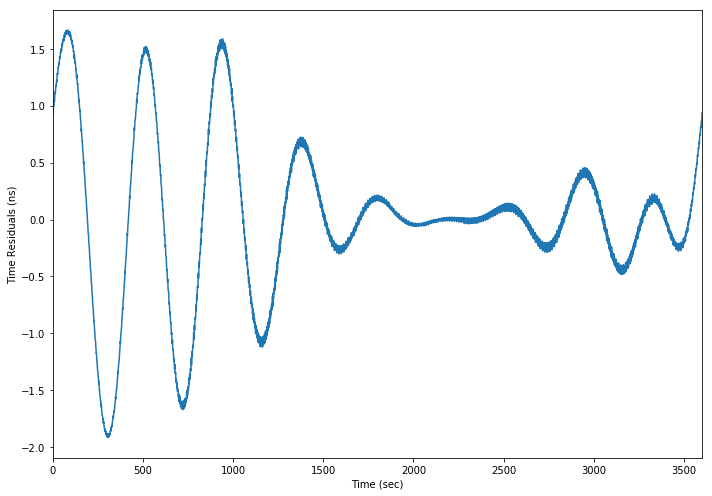

In [11]:
fig, ax1 = pl.subplots(figsize=(10,7))

ax1.plot(t-t[0], (deltaTsArrayFull[0]-deltaTsArray[0])*1e9)

ax1.set_ylabel('Time Residuals (ns)')
ax1.set_xlabel('Time (sec)')
ax1.set_xlim([0., (t[-1]-t[0])])

fig.tight_layout()

(array([ 813.,  106.,   32.,   15.,    8.,    3.,    4.,    8.,    2.,
           3.,    2.,    1.,    1.,    1.,    0.,    0.,    0.,    0.,
           0.,    1.]),
 array([  6.76381564e-03,   9.80608697e+00,   1.96054101e+01,
          2.94047333e+01,   3.92040564e+01,   4.90033796e+01,
          5.88027028e+01,   6.86020259e+01,   7.84013491e+01,
          8.82006722e+01,   9.79999954e+01,   1.07799319e+02,
          1.17598642e+02,   1.27397965e+02,   1.37197288e+02,
          1.46996611e+02,   1.56795934e+02,   1.66595258e+02,
          1.76394581e+02,   1.86193904e+02,   1.95993227e+02]),
 <a list of 1 Patch objects>)

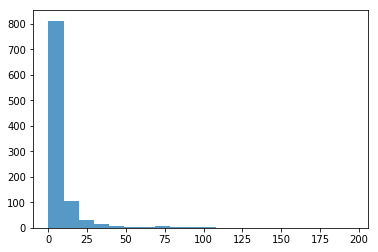

In [12]:
maxdt = []
for i in range(nbins):
    maxdt.append(np.max(np.fabs((deltaTsArrayFull[i]-deltaTsArray[i])*1e9)))

pl.hist(maxdt, bins=20, histtype='stepfilled', alpha=0.75)

In [13]:
# compare times
full = 0.00172*1e6 # time in microseconds

rom = 0.000000477*1e6*(Nb1 + Nb2) # time for computing time delay at nodes
rom += 28.0  # matrix multiplication (for first term)
rom += 15.9  # dot product for first term
rom += 27.8  # matrix multiplication (for second term)
rom += 17.0  # dot product for second term
rom += 53e-3 # combining terms for full time delay

In [14]:
print full, rom, (full/rom)

1720.0 105.925 16.2379041775


On the above examples see how well linear interpolation half-way between each of time stamps from delays calculated using the ROM compares to the full calculation at those new time positions.

(array([ 813.,  106.,   32.,   15.,    8.,    3.,    4.,    8.,    2.,
           3.,    2.,    1.,    1.,    1.,    0.,    0.,    0.,    0.,
           0.,    1.]),
 array([  6.76381564e-03,   9.80608697e+00,   1.96054101e+01,
          2.94047333e+01,   3.92040564e+01,   4.90033796e+01,
          5.88027028e+01,   6.86020259e+01,   7.84013491e+01,
          8.82006722e+01,   9.79999954e+01,   1.07799319e+02,
          1.17598642e+02,   1.27397965e+02,   1.37197288e+02,
          1.46996611e+02,   1.56795934e+02,   1.66595258e+02,
          1.76394581e+02,   1.86193904e+02,   1.95993227e+02]),
 <a list of 1 Patch objects>)

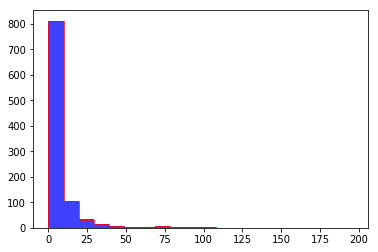

In [15]:
from scipy.interpolate import splrep, splev

newts = t[0:-1] + np.diff(t)/2.

maxdtsint = []
maxdtsintspl = []

for i in range(nbins):
    dtinterplinear = np.interp(newts, t, deltaTsArrayFull[i])
    tspl, cspl, kspl = splrep(t, deltaTsArrayFull[i])
    dtinterpspline = splev(newts, (tspl, cspl,  kspl))
    
    dtactual, _, _ = binary_model(w0[i], t[0]+T0[i]*Pb, Pb, asini[i], ecc[i], gamma[i], newts)
    
    maxdtsint.append(np.max(np.fabs((dtinterplinear-dtactual)*1e9)))
    maxdtsintspl.append(np.max(np.fabs((dtinterpspline-dtactual)*1e9)))

fig, ax = pl.subplots(1)
#ax.hist(maxdtsint, bins=20, histtype='stepfilled', color='r', alpha=0.75)
ax.hist(maxdtsintspl, bins=20, histtype='stepfilled', color='b', alpha=0.75)
ax.hist(maxdt, bins=20, histtype='step', color='r', alpha=0.75)

Now run the code on a variety of simulated binaries, but allow the period and projected semi-major axis to vary.

In [29]:
nbins = 1000

Pbmin = 60. # 6 second minimum
Pbmax = Pb*2.

#Pbs = Pb*10.*np.random.rand(nbins)
Pbs = np.linspace(Pbmin, Pbmax, nbins)
asini = 10.*np.random.rand(nbins)

eccmax = 0.1 # maximum eccentricity of the basis set
ecc = eccmax*np.random.rand(nbins)
w0 = 2.*np.pi*np.random.rand(nbins)
T0 = np.random.rand(nbins)

deltaTsArrayTrue = []

# get deltaTs calculated using interpolant
SUNew = []
dtvals = np.zeros(Nb1)

ts_nodes1 = np.loadtxt(os.path.join(rundir1, 'EIM_nodes.txt'))

# get deltats calculated using the reduced basis
for i in range(nbins):
    su, cu = eccentric_anomaly(t[0]+T0[i]*Pb, Pb, ecc[i], ts_nodes1)
        
    # create new version of deltaTs using empirical interpolant matrix
    SUNew.append(np.einsum('i,ij->j', su, B1))

    # get actual delays
    dtvals, _, _ = binary_model(w0[i], t[0]+T0[i]*Pbs[i], Pbs[i], asini[i], ecc[i], gamma[i], t)
    deltaTsArrayTrue.append(dtvals)

# get deltaTs calculated using interpolant
CUNew = []
dtvals = np.zeros(Nb2)

# get deltats calculated using the reduced basis
for i in range(nbins):
    su, cu = eccentric_anomaly(t[0]+T0[i]*Pb, Pb, ecc[i], ts_nodes2)
        
    # create new version of deltaTs using empirical interpolant matrix
    CUNew.append(np.einsum('i,ij->j', cu, B2))

deltaTsArrayFullNew = []
differences = []
for i in range(nbins):
    deltaTsArrayFullNew.append(binary_model_EA(w0[i], Pb, asini[i], ecc[i], gamma[i], SUNew[i], CUNew[i]))
    tspl, cspl, kspl = splrep((t-t[0])*Pbs[i]/Pb, deltaTsArrayFullNew[i])
    dtinterpspline2 = splev(np.mod(t-t[0], Pbs[i]), (tspl, cspl,  kspl))
    differences.append(np.max(np.fabs((dtinterpspline2-deltaTsArrayTrue[i])*1e9)))

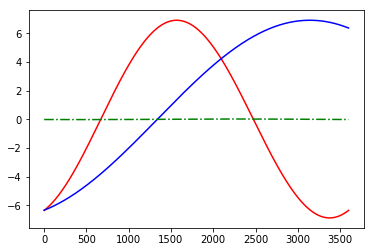

In [30]:
pl.plot(deltaTsArrayFullNew[-1], 'r')
pl.plot(deltaTsArrayTrue[-1], 'b')
pl.plot(dtinterpspline2-deltaTsArrayTrue[-1], 'g-.')

In [28]:
Pbs[-1]/3600.

5.5246785787520025

(array([ 936.,   39.,    6.,    6.,    3.,    3.,    1.,    3.,    2.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    1.]),
 array([  3.70304789e+00,   1.71496649e+08,   3.42993294e+08,
          5.14489939e+08,   6.85986585e+08,   8.57483230e+08,
          1.02897988e+09,   1.20047652e+09,   1.37197317e+09,
          1.54346981e+09,   1.71496646e+09,   1.88646310e+09,
          2.05795975e+09,   2.22945639e+09,   2.40095304e+09,
          2.57244968e+09,   2.74394633e+09,   2.91544297e+09,
          3.08693962e+09,   3.25843626e+09,   3.42993291e+09]),
 <a list of 1 Patch objects>)

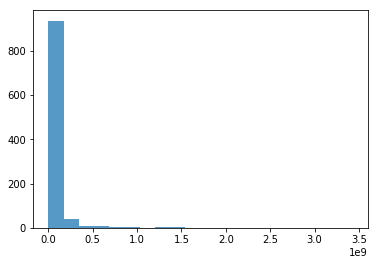

In [31]:
pl.hist(differences, bins=20, histtype='stepfilled', alpha=0.75)

In [224]:
differences[0:10], Pbs[0:10]

([20729.982463940643,
  304.12978113680822,
  356.42719131701028,
  1.3930424869190716,
  12751.378713815597,
  3195.6587038806106,
  123.85578962437194,
  1.2209787070283085,
  833.54892499443167,
  4.4238566143661728],
 array([  60.        ,   67.14714715,   74.29429429,   81.44144144,
          88.58858859,   95.73573574,  102.88288288,  110.03003003,
         117.17717718,  124.32432432]))

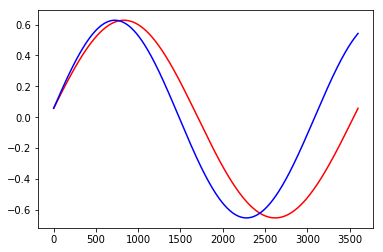

In [32]:
pl.plot(deltaTsArrayFullNew[430], 'r')
pl.plot(deltaTsArrayTrue[430], 'b')